In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
import imutils

import lightgbm as lgb

from skimage import util, exposure
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

from google.colab.patches import cv2_imshow
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
import PIL
import io
from base64 import b64decode, b64encode
import html
import time
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js


Thresholding : Teachnique used to segment images into regions based on pixel intensity.Especially useful in object detection, image segmentation and feature extraction.

coins in the image :  21


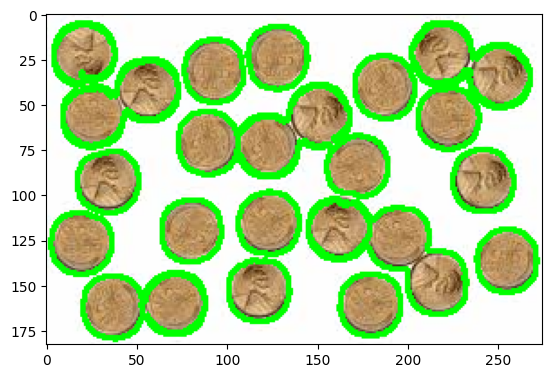

In [96]:
image = cv2.imread('/content/coins5.jpg')  # Read image from files
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert image to gray scale

# Use binary thresholding to covert grayscale into binary image of
# These take value 0 or 255 depending on either side of 127
# Resulting image is held in threshold
# Thresh binary indicates what kind of thresh to perform
# ret holds threshold value
ret,threshold = cv2.threshold(image,127,255,cv2.THRESH_BINARY)

# Gaussian Blur - Use weighted average of pixel with kernel that has higher values near center
# Helps with noise reduction, edge detection and image enhancement
# Especially in binary images
blur = cv2.GaussianBlur(gray, (11, 11), 0)
plt.imshow(blur,cmap = "gray")

# Canny edge detection algorithm with Sobel 3 (size of kernel)
# Uses the fact that at an edge there is usually going to be significant change in pixel intensity
canny = cv2.Canny(blur, 30, 150, 3)

# Performs morphological transformation of dialation with 1x1 kernel for 1 iteration
# Enhances foreground (coins) Suppresses background (whaterver)
dilated = cv2.dilate(canny, (1, 1), iterations=1)

# Detects boundaries within images and store detected contours in cnt
(cnt, hierarchy) = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# COnvert image back to RGB
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Based on output of findCOntours draw contours on image
cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)

print("coins in the image : ", len(cnt))
plt.imshow(rgb)

# # Problems - Cannot detect 2 or more coins taht are close to each other as seperate

In [94]:
coins2 = cv2.imread('/content/coins5.jpg')
gray2 = cv2.cvtColor(coins2, cv2.COLOR_BGR2GRAY)

# Use invert to highlight important part of image foreground becomes darker
# Otsu finds best treshold value
ret,thresh_coins2 = cv2.threshold(gray2,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Creating a 3x3 kernel
kernel_coins2 = np.ones((3,3), dtype=np.uint8)

# Perform morphological transformation of opening which
# first does erosion then dilation to clarify image
opening_coins2 = cv2.morphologyEx(thresh_coins2,cv2.MORPH_OPEN,kernel_coins2, iterations = 2)

# Assigns value based on distance to closest background pixel
# Makes sure to find what part of image is foreground
dist_transform = cv2.distanceTransform(opening_coins2,cv2.DIST_L2,5)

ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

int_fg = sure_fg.astype(np.uint8)

contours, hierarchy = cv2.findContours(int_fg.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(coins2, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, contours, -1, (0, 255, 0), 2)

print("coins in the image : ", len(contours))


coins in the image :  1


In [ ]:
# Shape Detection
shape2_image = cv2.imread('/content/shapes.jpg')
shape2_gray = cv2.cvtColor(shape2_image, cv2.COLOR_BGR2GRAY)
shape2_thresh = cv2.adaptiveThreshold(shape2_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,7)

shape2_cnts = cv2.findContours(shape2_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shape2_cnt = imutils.grab_contours(shape2_cnts)
for c in shape2_cnt:
    shape = ""
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)

    if len(approx) == 3:
        shape = "triangle"

    elif len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)

        shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

    # Pentagon
    elif len(approx) == 5:
        shape = "pentagon"

    # Otherwise assume as circle or oval
    else:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        shape = "circle" if ar >= 0.95 and ar <= 1.05 else "oval"
    x,y,w,h = cv2.boundingRect(c)
    cv2.putText(shape2_image, shape, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)


In [ ]:
shape2_image = cv2.imread('/content/shapes.jpg')
shape2_gray = cv2.cvtColor(shape2_image, cv2.COLOR_BGR2GRAY)
shape2_thresh = cv2.adaptiveThreshold(shape2_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,7)

shape2_cnts = cv2.findContours(shape2_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shape2_cnt = imutils.grab_contours(shape2_cnts)
for c in shape2_cnt:
    shape = ""
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)

    if len(approx) == 3:
        shape = "triangle"

    elif len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)

        shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

    # Pentagon
    elif len(approx) == 5:
        shape = "pentagon"

    # Otherwise assume as circle or oval
    else:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        shape = "circle" if ar >= 0.95 and ar <= 1.05 else "oval"
    x,y,w,h = cv2.boundingRect(c)
    cv2.putText(shape2_image, shape, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)


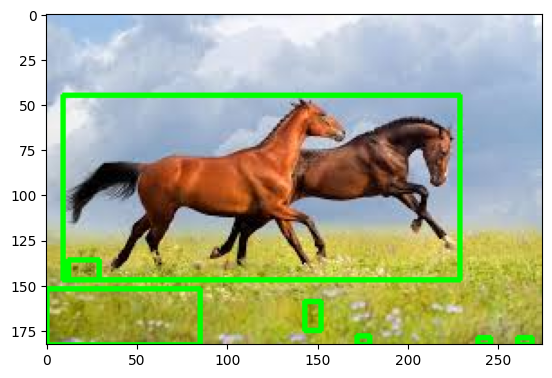

In [5]:
horse_img = cv2.imread("/content/horse3.jpg")
horse_gray = cv2.cvtColor(horse_img, cv2.COLOR_BGR2GRAY)

horse_blurred = cv2.GaussianBlur(horse_gray, (5,5), 0)
horse_thresh = cv2.threshold(horse_blurred,127,1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

horse_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
horse_dilated = cv2.dilate(horse_thresh,horse_kernel, iterations = 1)

horse_cnt = cv2.findContours(horse_dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
horse_cnt = imutils.grab_contours(horse_cnt)

for c in horse_cnt:
  x,y,w,h = cv2.boundingRect(c)
  cv2.rectangle(horse_img, (x,y), (x+w,y+h), (0,255,0), 2)

horse_rgb = cv2.cvtColor(horse_img, cv2.COLOR_BGR2RGB)
plt.imshow(horse_rgb)


Prediction is  Horse


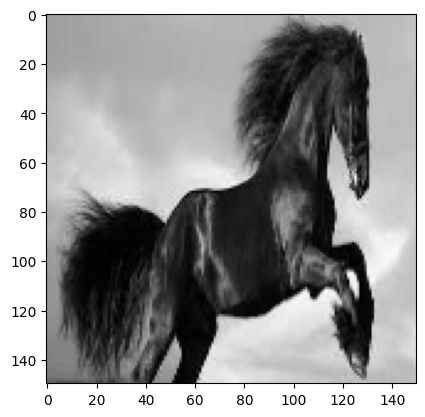

In [8]:
import os
Categories = ['Horse', 'Zebra']
data_dir = "/content/texture"

data = []


for category in Categories:
  path = os.path.join(data_dir, category)
  label = Categories.index(category)

  for img in os.listdir(path):

    img_path = os.path.join(path,img)
    pet_img = cv2.imread(img_path,0)
    pet_img = cv2.resize(pet_img, (150,150))
    img = np.array(pet_img).flatten()

    data.append([img,label])


# print(len(data))

feature = []
label = []

for features, labels in data:
  feature.append(features)
  label.append(labels)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(feature, label, test_size = 0.2)

test_img = x_test[0].reshape(150,150)
plt.imshow(test_img,cmap="gray")

from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(x_train, y_train)

prediction  = svc.predict(x_test)
accuracy = svc.score(x_test,y_test)

print("Prediction is ",Categories[prediction[0]])